# Atmospheric Rivers: run detection pipeline and QC outputs

This notebook will import the master processing function from the `ar_detection.py` module and run the entire processing workflow with minimal input. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
from ar_detection import detect_all_ars
from config import ard_fp, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp

In [2]:
detect_all_ars(ard_fp, 5, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp)

Getting axis length (km) for each AR target:: 100%|██████████| 43832/43832 [08:38<00:00, 84.55it/s] 
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 43832/43832 [09:15<00:00, 78.88it/s] 
Getting mean poleward strength for each AR target:: 100%|██████████| 43832/43832 [00:49<00:00, 876.83it/s] 
Getting directional coherence for each AR target:: 100%|██████████| 43832/43832 [02:31<00:00, 288.58it/s]
Getting total IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:19<00:00, 2219.58it/s]
Getting relative IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:19<00:00, 2204.13it/s]
100%|██████████| 17390/17390 [06:55<00:00, 41.86it/s] 


In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import shapely
from scipy.stats import circmean
from scipy.sparse.csgraph import connected_components


In [3]:
#import shps to gdfs
raw = gpd.read_file(landfall_6hr_fp)
events = gpd.read_file(landfall_events_fp)

#import ak shp
ak = gpd.read_file(ak_shp)
# reproject AK coastline to match AR CRS, and dissolve into one multipolygon
ak_ = ak.to_crs(raw.crs)
ak_d = ak_.dissolve()

In [4]:
#count number of landfalling ARs at individual 6hr timesteps
len(raw)

8293

In [5]:
#check AR attributes:
#all properties and criteria are preserved
#AR IDs (index) are unique integers, could also be labeled using year / month / etc

raw.head()

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry
0,3,1992-01-01 06:00:00,2.0,3.5,4854,37,221,87,358,2230418,488,1,1,1,1,1,5,"POLYGON ((-149.62500 61.12500, -149.37500 61.1..."
1,4,1992-01-01 12:00:00,4.0,4.2,3773,38,224,85,0,2233790,443,1,1,1,1,1,5,"POLYGON ((-143.12500 60.62500, -142.62500 60.6..."
2,21,1992-01-08 00:00:00,2.0,3.8,5254,24,232,81,360,3547765,569,1,1,1,1,1,5,"POLYGON ((-145.62500 60.62500, -145.12500 60.6..."
3,22,1992-01-08 06:00:00,2.0,3.7,4862,27,229,83,1,3182008,575,1,1,1,1,1,5,"POLYGON ((-135.87500 58.62500, -134.62500 58.6..."
4,24,1992-01-08 18:00:00,1.0,2.3,4606,12,249,77,1,3141921,530,1,1,1,1,1,5,"POLYGON ((-146.37500 60.62500, -142.37500 60.6..."


(25.0, 72.0)

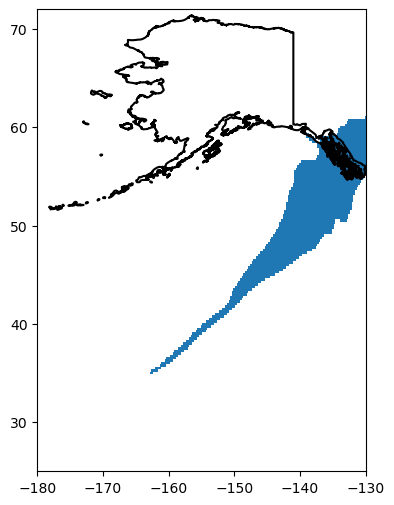

In [6]:
#plot a random datetime from the raw Alaska ARs
#these shapes represent landfalling ARs at individual 6hr timesteps...
#run this cell multiple times to get an idea of what some of these look like

random_date = random.choice(list(raw.index))
fig, ax = plt.subplots(figsize=(6,6))
#plt.suptitle)

ak_d.boundary.plot(ax=ax, color='black')
raw[raw.index==random_date].plot(ax=ax)

plt.xlim([-180, -130])
plt.ylim([25, 72])

In [7]:
#count number of landfalling AR events when grouped by adjacent dates
len(events)

1802

In [8]:
#average landfalling AR events per year ...  is this figure reasonable?
len(events)/30

60.06666666666667

In [9]:
#check attributes:
#event IDs are unique integers, could also be labeled using year / month / etc
#start and end columns can be parsed as datetime objects to get approximate duration
#multipolygons can be dissolved into single polygon representing entire AR impact area
#properties are disregarded during the grouping operation - could these values be aggregated somehow?

events.head()

,index,start,end,sumtot_str,sumrel_str,ratio_m,len_km_m,orient_m,poleward_m,dircoher_m,mean_dir_m,dur_hrs,tintensity,rintensity,geometry
0,0,1992-01-01 06:00:00,1992-01-01 12:00:00,4464208,931,4.0,4314.0,38.0,222.0,86.0,179.0,12.0,372017.0,78.0,"MULTIPOLYGON (((-142.62500 60.62500, -142.6250..."
1,1,1992-01-08 00:00:00,1992-01-09 12:00:00,11701322,2048,3.0,4714.0,19.0,235.0,79.0,92.0,42.0,278603.0,49.0,"MULTIPOLYGON (((-153.37500 24.37500, -153.3750..."
2,2,1992-01-11 06:00:00,1992-01-11 12:00:00,1862329,962,2.0,3063.0,-2.0,252.0,64.0,350.0,12.0,155194.0,80.0,"POLYGON ((-179.12500 33.37500, -179.12500 35.8..."
3,3,1992-01-13 12:00:00,1992-01-19 00:00:00,26891085,4532,3.0,4496.0,18.0,236.0,82.0,38.0,138.0,194863.0,33.0,"POLYGON ((-152.87500 26.12500, -152.87500 25.8..."
4,4,1992-01-25 06:00:00,1992-01-26 12:00:00,3045136,1060,2.0,2904.0,-20.0,271.0,74.0,126.0,36.0,84587.0,29.0,"POLYGON ((-155.12500 57.37500, -155.12500 57.1..."


In [11]:
circmean([5,6,354,355], 360)

360.0

In [17]:
def circ_mean(x):
    return circmean(x, high=360)

In [25]:
ak_ars = raw
ak_ars['dt'] = pd.to_datetime(raw['time'])

#limited subset containing a known multi-AR event
ak_ars = ak_ars[(ak_ars['dt'] > '2020-01-01') & (ak_ars['dt'] < '2020-03-01')].copy()

#below is function for ar_detection.py
ak_ars["diff"] = ak_ars["dt"].diff().dt.days.gt(1).cumsum()

dfs = []

for d in ak_ars["diff"].unique():
    sub = ak_ars[ak_ars["diff"] == d].copy()

    overlap_matrix = sub.geometry.apply(lambda x: sub.geometry.intersects(x)).values.astype(int)
    n, labels = connected_components(overlap_matrix)
    sub['group'] = labels
    sub['start'] = sub['dt']
    sub['end'] = sub['dt']
    sub["sumtot_str"] = sub["tot_str"]
    sub["sumrel_str"] = sub["rel_str"]
    sub['ratio_m'] = sub['ratio']
    sub['len_km_m'] = sub['length']
    sub['orient_m'] = sub['orient']
    sub['poleward_m'] = sub['poleward']
    sub['dircoher_m'] = sub['dir_coher']
    sub['mean_dir_m'] = sub['mean_dir']

    res = sub.dissolve(by='group', aggfunc={
         "start": "min",
         "end": "max",
         "sumtot_str": "sum",
         "sumrel_str": "sum",
         "ratio_m": "mean",
         "len_km_m": "mean",
         "orient_m": circ_mean,
         "poleward_m": "mean",
         "dircoher_m": "mean",
         "mean_dir_m": circ_mean}
         )

    for i in res.index:
        #calculate duration from datetime columns
        #after subtracting, add 6hrs as minimum event length.... this assures a single timestep event is not zero duration!
        res.loc[i, 'dur_hrs'] = ((res['end'][i]-res['start'][i]).total_seconds()/3600) + 6

    #calculate total and relative intensity
    res['tintensity'] = res['sumtot_str']/res['dur_hrs']
    res['rintensity'] = res['sumrel_str']/res['dur_hrs']

    res = res.round({
        'ratio_m': 0, 
        'len_km_m': 0, 
        'orient_m': 0, 
        'poleward_m':0, 
        'dircoher_m':0, 
        'mean_dir_m':0, 
        'dur_hrs':0,
        'tintensity':0,
        'rintensity':0
        })

    dfs.append(res)

    events = pd.concat(dfs)
    events = events.reset_index(drop=True).rename(columns={'index': 'event_id'})
    #events.crs = ars.crs

    # reset datetime columns as strings for output (datetime fields not supported in ESRI shp files)
    events["start"] = events["start"].astype(str)
    events["end"] = events["end"].astype(str)

#     # export condensed event AR geodataframe to shp
#     events.to_file(fp_events, index=True)

In [26]:
events

,geometry,start,end,sumtot_str,sumrel_str,ratio_m,len_km_m,orient_m,poleward_m,dircoher_m,mean_dir_m,dur_hrs,tintensity,rintensity
0,"MULTIPOLYGON (((-119.87500 46.37500, -119.8750...",2020-01-03 18:00:00,2020-01-04 00:00:00,2735451,870,3.0,3319.0,14.0,230.0,72.0,359.0,12.0,227954.0,72.0
1,"POLYGON ((-148.12500 57.62500, -148.12500 57.3...",2020-01-11 06:00:00,2020-01-12 06:00:00,4313819,803,3.0,3322.0,4.0,217.0,71.0,3.0,30.0,143794.0,27.0
2,"POLYGON ((-164.37500 34.37500, -164.37500 34.1...",2020-01-14 18:00:00,2020-01-16 06:00:00,13404131,3325,4.0,3686.0,346.0,286.0,73.0,1.0,42.0,319146.0,79.0
3,"POLYGON ((-119.87500 48.37500, -119.87500 48.1...",2020-01-23 06:00:00,2020-01-23 12:00:00,4274530,868,4.0,4376.0,24.0,225.0,76.0,3.0,12.0,356211.0,72.0
4,"POLYGON ((-147.37500 60.87500, -145.37500 60.8...",2020-01-29 00:00:00,2020-01-29 12:00:00,15717410,1673,3.0,5448.0,31.0,224.0,76.0,358.0,18.0,873189.0,93.0
5,"MULTIPOLYGON (((-130.37500 56.87500, -130.1250...",2020-02-04 00:00:00,2020-02-05 12:00:00,19456261,2622,3.0,4153.0,35.0,212.0,79.0,2.0,42.0,463244.0,62.0
6,"POLYGON ((-135.62500 61.87500, -130.87500 61.8...",2020-02-09 00:00:00,2020-02-09 00:00:00,1229448,289,3.0,2605.0,43.0,209.0,73.0,9.0,6.0,204908.0,48.0
7,"POLYGON ((-178.62500 29.62500, -178.62500 29.3...",2020-02-10 12:00:00,2020-02-10 18:00:00,2462488,967,3.0,3504.0,1.0,254.0,58.0,356.0,12.0,205207.0,81.0
8,"POLYGON ((-154.87500 39.87500, -154.87500 39.6...",2020-02-13 12:00:00,2020-02-13 18:00:00,3204310,765,2.0,2812.0,322.0,260.0,68.0,0.0,12.0,267026.0,64.0
9,"MULTIPOLYGON (((-167.37500 38.62500, -167.6250...",2020-02-16 18:00:00,2020-02-21 12:00:00,11180789,3556,3.0,2529.0,20.0,236.0,74.0,4.0,120.0,93173.0,30.0
